<a href="https://colab.research.google.com/github/chase-capron/ImageProcessing/blob/master/FinalImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [236]:
# Importing necessary Image Processing libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
%matplotlib inline

# Uploading File to Colab notebook
from google.colab import files
uploaded = files.upload()

# Used to verify if file has been uploaded
for file in uploaded.keys():
  print('Uploaded file "{name}" with length {length} bytes'.format(name=file, length=len(uploaded[file])))

Saving Test2.png to Test2.png
Uploaded file "Test2.png" with length 156724 bytes


In [0]:
# Function used to display image onto screen
def display(im, title=None, **kwargs):
    kwargs['cmap'] = 'gray'
    plt.figure() # Creates a seperate window for viewing an Image
    plt.imshow(im, **kwargs) # Displays the image using cmap arguments
    plt.title(title)
    plt.axis('off') # Turns off the plot axis's to just display the Image
    return im

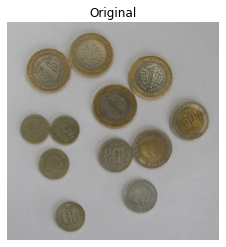

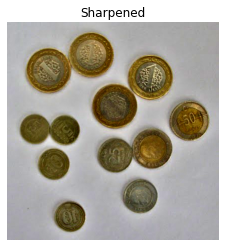

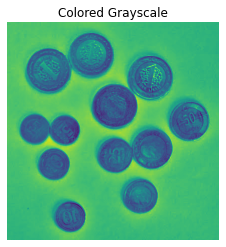

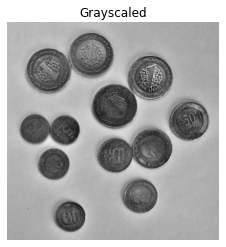

In [254]:
# Reads in the Image file to an array my_image
# To use another Image, upload multiple images and replace the file name in my_image
my_image = plt.imread('Test2.png') # [Insert file name here]

# Mask to Sharpen the Image for pre-processing (Helps distinquish coins from background)
from skimage.filters import unsharp_mask
rad = 20.0 # Change this to adjust Sharpening intensity
sharp_im = unsharp_mask(my_image, radius = rad) # New Sharpened Image

# Displaying Original and new Sharpened Image
display(my_image, 'Original', cmap=None) # Display uploaded Image
display(sharp_im, 'Sharpened', cmap=None) # Display Sharpened Image

# Creating Colored Grayscale
heat = color.rgb2gray(sharp_im) # Defaults to Grayscaling the image as a colored Heatmap just for reference
plt.figure()
plt.imshow(heat)
plt.title('Colored Grayscale')
plt.axis('off')

# Creating True Grayscale with Color Map
gray = display(heat, 'Grayscaled') # No cmap argument defaults to cmap='gray'

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

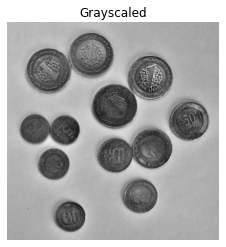

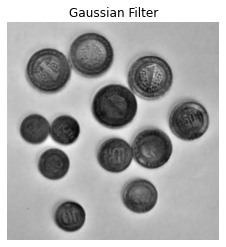

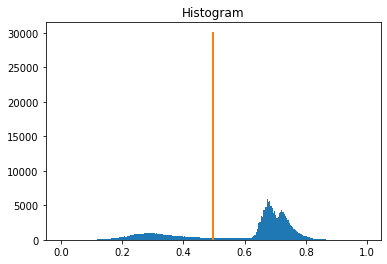

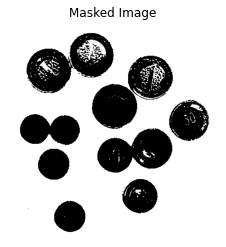

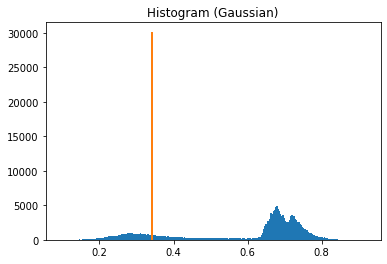

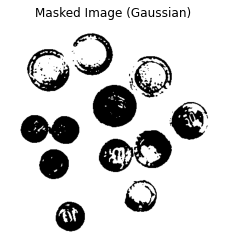

In [255]:
# Creating a Thresholding Mask
from skimage.filters import threshold_otsu, gaussian

# Using a Gaussian filter to blur the image before thresholding
S = 1 # Adjustable variable for the amount of blur
gaussian_filt = gaussian(gray, sigma=S)
gray = display(heat, 'Grayscaled')
gaussian = display(gaussian_filt, 'Gaussian Filter', cmap=None)
thresh1 = threshold_otsu(gray, nbins=5) # Determines the Threshold value for the border of coins, 5 bins optimizes the coins seen
thresh2 = threshold_otsu(gaussian, nbins=5)
binary1 = gray > thresh1  # New Binary mask
binary2 = gaussian > thresh2

plt.figure()
plt.hist(gray.ravel(), bins=250); # Displays Histogram of Gray values in Image
plt.title('Histogram')
plt.plot([thresh1, thresh1], [0,30000], linewidth=2)

display(binary1, 'Masked Image') # Displays the new Binary Image

plt.figure()
plt.hist(gaussian.ravel(), bins=250); # Displays histogram of grey values in image
plt.title('Histogram (Gaussian)')
plt.plot([thresh2, thresh2], [0,30000], linewidth=2) # Plot's Threshold

display(binary2, 'Masked Image (Gaussian)')

Since the binary image still has dark spots in areas that are inside the coin, these must be filled in, using the morphology library from skimage

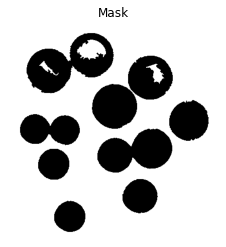

In [256]:
from skimage import morphology
from skimage.morphology import disk

no_white = morphology.remove_small_objects(binary1, min_size=150) # Removes white holes
disks = morphology.binary_closing(no_white, disk(1))

mask_filter = ~morphology.remove_small_objects(~disks) # Removes the inverse of small white objects, (removes small black holes in the coins), and reverts to black

mask = display(mask_filter, 'Mask')

array([[0.72130084, 0.72130084, 0.72130084, ..., 0.64732665, 0.6434051 ,
        0.6434051 ],
       [0.7173792 , 0.7173792 , 0.7173792 , ..., 0.6434051 , 0.6394836 ,
        0.6394836 ],
       [0.7134576 , 0.7134576 , 0.7134576 , ..., 0.63556194, 0.63556194,
        0.63556194],
       ...,
       [0.6493059 , 0.6493059 , 0.6493059 , ..., 0.6624773 , 0.6624773 ,
        0.6624773 ],
       [0.6493059 , 0.6493059 , 0.6532275 , ..., 0.6624773 , 0.6624773 ,
        0.6624773 ],
       [0.65519965, 0.65519965, 0.65519965, ..., 0.6627451 , 0.66331065,
        0.6593891 ]], dtype=float32)

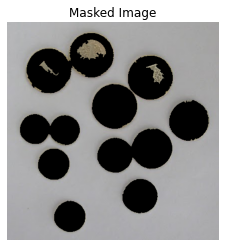

<Figure size 432x288 with 0 Axes>

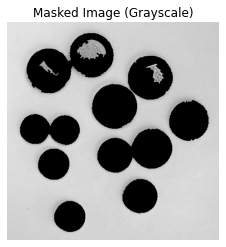

In [257]:
# Applies the mask to the original image of the coins
my_image[~mask] = 0 # Applies black mask to image
plt.imshow(my_image)
plt.title('Masked Image')
plt.axis('off')
plt.figure()

# Used to display Grayscale of Masked Image
gray_mask = color.rgb2gray(my_image)
display(gray_mask, 'Masked Image (Grayscale)')

Number of coins: 12


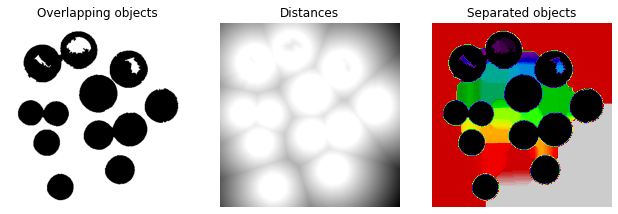

In [259]:
'''This section is referenced from watershed documentation by scikit at
 https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html'''
 
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

distance = ndi.distance_transform_edt(mask)
local_max = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=mask)
markers = ndi.label(local_max)[0]
labels = watershed(-distance, markers, mask=mask)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(mask, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')
regions = regionprops(labels)

regions = [r for r in regions if r.area > 600]

print('Number of coins:', len(regions) - 1)

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()